## Introduction

This project was to find a way to reduce the number of alarms in NICU for nurses to avoid alarm fatigue with effective and interpretive features. What we had was the alarms and the vital sign parameters like SpO2, HR and BR in the whole monitoring hours of 18 patients<br>
After discussing with nurses and doctors, we were supposed to focus on yellow and red alarms from monitoring system since their high false positive rate and importance for healthcare providers

## Project Design

Import the necessary library and see what the original alarm data looks like

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import itertools
import seaborn as sns
from itertools import combinations,chain
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
from scipy import stats,interpolate
from lempel_ziv_complexity import lempel_ziv_complexity

Info: numba.jit seems to be available.


In [2]:
abspath='C:/1Research/Dataset_Baby/'###Path of original data in my PC
basepath = os.getcwd()
filepath = os.path.abspath(os.path.join(basepath, "..", "Processed",'Monitor alarms_startBased'))
babies=['01_6f712b8a-89a9-4a1a-ad91-4b9ed6fc13ea','02_b2bd7687-8dda-4761-a849-ed3e51640b22','03_fd85bfb5-292e-4657-a430-1ee5c31f5f00',
     '04_92f19a7a-3671-446b-ba91-0c21d7d9174d','05_14a1e090-ce93-4131-a2a9-ca8ca043ce98','06_69f39a14-7087-4f68-b91b-bc33a483e1bc',
     '07_df1ef995-596c-403e-b490-e8d88a9b1bce','08_de07337a-e679-4fd3-b606-3ab106792edd','09_5b5b49c6-1539-47c7-919c-987a1c23ea34',
     '10_68f7b1d9-309c-4448-8c25-be88590254c7','11_244d51f1-8788-403b-8eea-5ef489a02379','13_b825cb6f-4744-423c-a782-b67e3d62e359',
     '14_c6b0bb8d-b512-48a1-81f1-4ad8054d9392','15_ce30cfa9-0148-4775-aed1-086e46d2d25f','16_b360d41c-2b87-4b73-95a9-33d0aa3c8fc5',
     '17_f0fea76b-095b-484a-995e-7f11efc286d9','19_67749c57-efa7-49f5-8d3e-8b6a50fe4408','20_fcd8ed2e-b485-4acc-bad2-b467d25cb544']
pd.read_csv(abspath+babies[0]+'/Alarms.csv',skiprows=3).head()

,Timestamp,Severity,Label,AnnounceTime,EndTime,alarmDuration,IsSilenced
0,2016-12-06 14:16:14.669,Silent Cyan,SpO₂ zwak signaal,2016-12-06 14:16:08.525,2016-12-06 14:16:22.861,14,0
1,2016-12-06 14:16:45.389,Cyan,SpO₂ sensor los,2016-12-06 14:16:50.509,2016-12-06 14:16:52.557,2,0
2,2016-12-06 14:16:55.629,Cyan,SpO₂ geen puls,2016-12-06 14:17:00.749,2016-12-06 14:17:03.821,3,0
3,2016-12-06 14:17:31.469,2_Yellow,✱✱SpO₂ 80 <85,2016-12-06 14:17:18.157,2016-12-06 14:17:39.661,21,0
4,2016-12-06 14:18:02.189,Silent Cyan,SpO₂ zwak signaal,2016-12-06 14:17:23.277,2016-12-06 14:18:11.405,48,0


As we know from nurses, the yellow and red alarms in monitoring system are parameter threshold related and more important.<br>Hence, we extracted all yellow and red alarms from monitoring system and made the table more organized

In [4]:
### Related functions
def getalarms(babyname):
    #Keep all yellow and red alarms in monitoring alarms,remove others
    alarm=pd.DataFrame()
    for baby in babyname:
        ##Absolute path of original baby data, need to be changed in other PC
        alarm_temp=pd.read_csv(abspath+baby+'/Alarms.csv',skiprows=3)
        alarm_temp['Baby']=baby               
        alarm_temp=alarm_temp[['Baby','Severity','Label','AnnounceTime','EndTime','alarmDuration']]
        ##Focus on yellow and red alarms
        alarm_temp=alarm_temp[alarm_temp['Severity'].str.contains('Yellow|Red')]
        alarm_temp['Label']=alarm_temp['Label'].replace('✱.*✱','',regex=True)
        ##Keep the monitor alarms
        alarm_temp=alarm_temp[alarm_temp['Label'].str.contains(
                'NiBDm|ABPm|HF|Pols|SpO|Brady|Apne|fibr|asyst|Tachy|Desat')]        
        #convert it to datetime for calculation
        alarm_temp[['AnnounceTime','EndTime']]=alarm_temp[['AnnounceTime','EndTime']].apply(pd.to_datetime)        
        alarm=pd.concat([alarm, alarm_temp])
    return alarm

In [5]:
### Main part
alarm=getalarms(babies)
alarm.head()

,Baby,Severity,Label,AnnounceTime,EndTime,alarmDuration
3,5b5b49c6-1539-47c7-919c-987a1c23ea34,2_Yellow,SpO₂ 80 <85,2016-12-06 14:17:18.157,2016-12-06 14:17:39.661,21
9,5b5b49c6-1539-47c7-919c-987a1c23ea34,2_Yellow,SpO₂ 78 <85,2016-12-06 14:19:29.229,2016-12-06 14:19:31.277,2
39,5b5b49c6-1539-47c7-919c-987a1c23ea34,2_Yellow,SpO₂ 78 <85,2016-12-06 22:11:59.693,2016-12-06 22:13:00.109,61
42,5b5b49c6-1539-47c7-919c-987a1c23ea34,1_Red,Desat 78 < 80,2016-12-06 23:30:34.189,2016-12-06 23:30:38.285,4
44,5b5b49c6-1539-47c7-919c-987a1c23ea34,1_Red,Desat 63 < 80,2016-12-06 23:31:01.837,2016-12-06 23:31:05.933,4


It can be seen that the first 3 rows actually belong to one category named SpO2 Low, similarly these labels can fall into several categories like SpO2 High, HR low... Besides it is reasonable that some yellow alarm may turn to red alarm in some time. Therefore we created one new column to record the category of the alarm and extracted yellow alarms, red alarms and the yellow to red alarm which represent the yellow turn to red alarm, let's assure, in one minute.

In [7]:
### Related functions
### Get yellow-to-red alarms based on our 1-min definition,if the yellow trigers multiple reds, 
##we consider first one, if the first several reds happen simultanously, we consider them all.
def getYtR(yellow,red,tw_YtR):
    yellow_to_red=pd.DataFrame()
    yellow_endtime=[]
    yellow_announcetime=[]
    yellow_label=[]
    yellow_dur=[]
    red=red.groupby(['Baby'])
    for baby,announcetime,endtime,label,dur in zip(yellow['Baby'], yellow['AnnounceTime'], 
                                                   yellow['EndTime'],yellow['Label'],
                                                   yellow['alarmDuration']):
        temp=red.get_group(baby)
        red_temp=temp[(temp.AnnounceTime>announcetime) & 
                      (temp.AnnounceTime<=announcetime+pd.Timedelta(minutes=tw_YtR))]
        ## The yellow alarm followed by red in tw mins
        if len(red_temp)!=0:
            ##Consider the first red caused by yellow
            first_red=red_temp[red_temp['AnnounceTime']==np.min(red_temp['AnnounceTime'])]
            yellow_to_red=pd.concat([yellow_to_red,first_red])
            ##Store corresponding yellow alarm information, deal with red alarms triggered at the same time.
            yellow_endtime.extend([str(endtime)]*len(first_red))
            yellow_announcetime.extend([str(announcetime)]*len(first_red))
            yellow_label.extend([label]*len(first_red))
            yellow_dur.extend([str(dur)]*len(first_red))
    yellow_to_red.drop(['Severity'],axis=1,inplace=True)
    yellow_to_red['Label_yellow']=yellow_label
    yellow_to_red['alarmDuration_yellow']=yellow_dur
    yellow_to_red=yellow_to_red.rename(columns={'AnnounceTime': 'AnnounceTime_red',
                                                'Label': 'Label_red',
                                                'EndTime': 'EndTime_red',
                                                'alarmDuration': 'alarmDuration_red'})
    yellow_to_red['EndTime_yellow']=pd.to_datetime(yellow_endtime) 
    yellow_to_red['AnnounceTime_yellow']=pd.to_datetime(yellow_announcetime) 
    ###convert TransitionTime to seconds
    yellow_to_red['TransitionTime']=pd.to_timedelta(yellow_to_red['AnnounceTime_red']-
                 yellow_to_red['AnnounceTime_yellow'])/np.timedelta64(1, 's')
    return yellow_to_red
### Create specific alarm category like SpO2 Low, HR Low.etc.
def category(Label,color):
    ##Add the alarm category into yellow_to_red for visualization and statistics
    if color=='yellow':
            Label=Label.replace([' .*[0-9].*<.*[0-9].*',' .*[0-9].*>.*[0-9].*','SpO.* ','HF'],[
                    ' Low',' High','SpO2 ','HR'],regex=True)        
    elif color=='red':
        Label=Label.replace(['.*Desat.*','.*Brady.*','.*Apneu.*',
             '.*ABPm.*<.*','.*ABPm.*>.*','.*Tachy.*>.*'],['Desat','Brady','Apnea','ABPm too Low','ABPm too High',
             'Tachy too High'],regex=True)
    return Label

In [8]:
### Main part
tw_YtR = 1  ###Difine the time window of yellow to red (min)
##Extract yellow alarms
yellow=alarm[alarm['Severity'].str.contains('Yellow')]
yellow['Category']=category(yellow['Label'],'yellow')
##Extract red alarms
red=alarm[alarm['Severity'].str.contains('Red')]
red['Category']=category(red['Label'],'red')
##Extract yellow to red alarms
yellow_to_red=getYtR(yellow,red,tw_YtR)
yellow_to_red['Category_red']=category(yellow_to_red['Label_red'],'red')
yellow_to_red['Category_yellow']=category(yellow_to_red['Label_yellow'],'yellow')
##Extract yellow to Desat and Brady
yellow_to_Desat=yellow_to_red[yellow_to_red['Label_red'].str.contains('Desat')]
yellow_to_Brady=yellow_to_red[yellow_to_red['Label_red'].str.contains('Brady')]
##Extract yellow to no red
yellow_to_notred=pd.merge(yellow,yellow_to_red,how='outer',left_on=['EndTime','Baby','Label'],right_on=['EndTime_yellow','Baby','Label_yellow'])
yellow_to_notred=yellow_to_notred[yellow_to_notred['Label_red'].isnull()]
yellow_to_notred=yellow_to_notred[['Baby','Label','AnnounceTime','EndTime','alarmDuration']]
yellow_to_notred['Category']=category(yellow_to_notred['Label'],'yellow')

Visualize yellow and red alarm data

Text(0.5,1,'All alarms(95k) ')

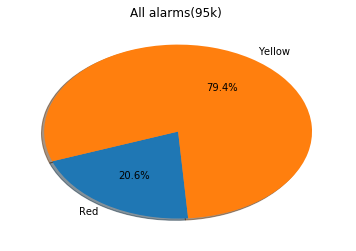

In [9]:
plt.pie([len(red),len(yellow)],
        labels=['Red','Yellow'],
        autopct='%1.1f%%', 
        shadow=True, 
        startangle=200) 
plt.title('All alarms(%ik) ' %(len(alarm)//1000))

We can see that No. of yellow alarms was much more than that of red alarms, moreover yellow alarms were not life-threatening. To reduce more alarms, maybe it is better to put our effort on yellow alarms.<br>Let's see how many yellow alarms turned to red alarms in one minute

Text(0.5,1,'Yellow alarms(75k)')

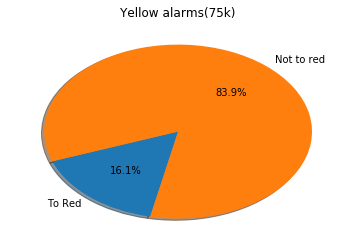

In [10]:
plt.pie([len(yellow_to_red),len(yellow)-len(yellow_to_red)],
        labels=['To Red','Not to red'],
        autopct='%1.1f%%', 
        shadow=True, 
        startangle=200) 
plt.title('Yellow alarms(%ik)' %(len(yellow)//1000))

Nice! Most of yellow alarms did't turn to red alarms which means they recovered themselves. In this case, if we could predict which yellow alarms would turn to red and which would not, we could reduce all the safe yellow alarms and get to know those red alarms in advance. Namely, we can reduce a large amount of yellow alarms and get extra time for nurses to deal with the really dangerous condition, red alarms.<br> **So our goal becomes to detect the yellow alarms which would turn to red alarms in one minute.**let's start from study the yellow alarms further.

In [17]:
### Related functions
def pieplot(n,groupby,alarms,title):
    component=alarms.groupby([groupby]).count().sort_values(by=['Baby'],ascending=False)
    first=[component.iloc[x,1] for x in range(n)]
    size=first+[len(alarms)-np.sum(first)]
    label=[component.index[x] for x in range(n)]+['Others']
    plt.pie(size, labels=label,autopct='%1.1f%%', shadow=True, startangle=200)
    plt.title(title)

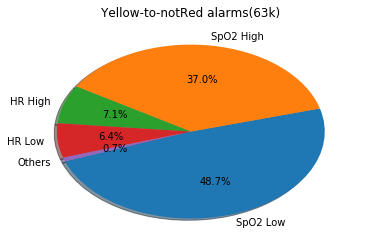

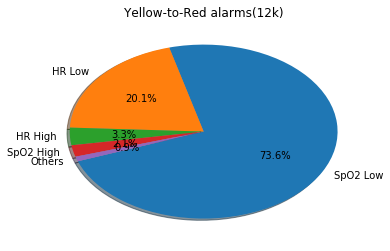

In [18]:
pieplot(n=4,groupby='Category',alarms=yellow_to_notred,title='Yellow-to-notRed alarms(%ik)' %(len(yellow_to_notred)//1000))
plt.figure()
pieplot(n=4,groupby='Category_yellow',alarms=yellow_to_red,title='Yellow-to-Red alarms(%ik)' %(len(yellow_to_red)//1000))
plt.show()

These two pie chart indicated that SpO2 Low and HR Low were most important cause for yellow to red.<br>Let's check this by seeing the component of yelow-to-red alarms from red perspective

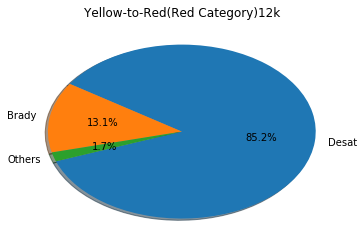

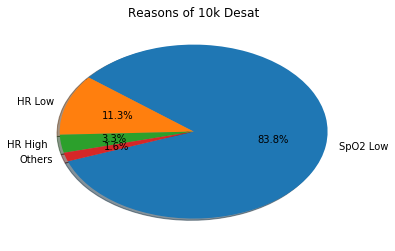

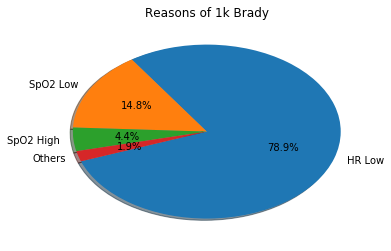

In [19]:
pieplot(n=2,groupby='Category_red',alarms=yellow_to_red,title='Yellow-to-Red(Red Category)%ik' %(len(yellow_to_red)//1000))
plt.figure()
pieplot(n=3,groupby='Category_yellow',alarms=yellow_to_Desat,title='Reasons of %ik Desat' %(len(yellow_to_Desat)//1000))
plt.figure()
pieplot(n=3,groupby='Category_yellow',alarms=yellow_to_Brady,title='Reasons of %ik Brady' %(len(yellow_to_Brady)//1000))
plt.show()

As expected, Desaturation and Brady were main component of yellow-to-red alarms and they were normally caused by SpO2 Low and HR Low respectively. **So the category of yellow alarms can be a good feature for our detection**

By the way, the transition time of these yellow-to-red alarms was extracted.

Text(0.5,1,'PDF of TransitionTime for Yellow to Red')

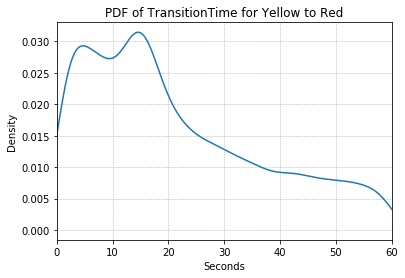

In [20]:
ax=yellow_to_red['TransitionTime'].plot(kind='kde',legend=False)
plt.grid(linestyle='--', linewidth=0.5)
ax.set_xlim(0,60)
ax.set_xlabel('Seconds')
plt.title('PDF of TransitionTime for Yellow to Red')

Majority of red alarms were triggered a few seconds after yellow alarm, that is to say, we'd better to detect these yellow-to-red alarms before the yellow alarm occured, the 'future data' can't be borrowed, otherwise the detection would make less sense.

## Data Preprocessing

After setting our specific goal, we determined to extract the SpO2 HR and BR information one minute before the yellow alarm happened to make this classification.

In [15]:
### Related functions
### Extract parameters tw_param mins before and after each yellow alarm
def getparams(babies,paramname,alarm_df,tw_param,tw_YtR): 
    ###In some tables like yellow_to_notred, AnnounceTime column is named as AnnounceTime_yellow
    if 'AnnounceTime' not in alarm_df.columns:
        alarm_df.rename(columns={'AnnounceTime_yellow':'AnnounceTime'},inplace=True)
    if 'alarmDuration' not in alarm_df.columns:
        alarm_df.rename(columns={'alarmDuration_yellow':'alarmDuration'},inplace=True)    
    result=pd.DataFrame()##store final results
    for baby in babies:
        param=pd.DataFrame(np.array(range(-60*tw_param,tw_YtR*60+1)),columns=['Instant'])
        alarm_temp=alarm_df[alarm_df['Baby']==baby]
        param_temp=pd.read_csv(abspath+baby+'/Numeric/'+paramname+'.csv',
                               usecols=[1,2],header=None,names=[paramname,'Timestamp'])        
        param_temp['Baby']=baby
        ## Convert it to datetime for subsequent calculation
        param_temp['Timestamp']=pd.to_datetime(param_temp['Timestamp'])
        alarm_dur=[]### To store duration
        ## Find params 3mins before and after this alarm Timestamp for this baby
        for time,dur in zip(alarm_temp['AnnounceTime'],alarm_temp['alarmDuration']):
            temp=param_temp[(param_temp['Timestamp']<time+pd.Timedelta(seconds=tw_YtR*60+0.5)) & 
                            (param_temp['Timestamp']>=time-pd.Timedelta(seconds=60*tw_param+0.5))]            
            ## Extract param when it contains more than 90% valid value and the original sampled value contains no more than 1/30 consecutive Nans
            if (temp.loc[:,temp.columns[0]].count()>(tw_param+tw_YtR)*54) & (consNan(temp.loc[:,temp.columns[0]])<(tw_param+tw_YtR)*2):
                ## Record max and min value in this period to replace unreasonable values after interpolation
                maximum=temp[paramname].max()
                minimum=temp[paramname].min()
                temp['Instant']=(temp['Timestamp']-time)/np.timedelta64(1, 's')
                ### In some cases there is duplicated instant, drop it
                temp=temp.drop_duplicates('Instant')
                ### Cubic interpolate first, then resample at needed instant
                tck=interpolate.splrep(temp.loc[temp.iloc[:,0].notnull(),'Instant'].values,
                                                temp.iloc[:,0].dropna().values)
                temp=interpolate.splev(np.array(range(-60*tw_param,tw_YtR*60+1)), tck)
                ## Replace the unreasonable values
                temp[temp>maximum*1.1]=maximum
                temp[temp<minimum*0.9]=minimum
                param=pd.concat([param,pd.Series(temp,name=time)],axis=1)
                alarm_dur.append(dur)
        param=param.set_index('Instant').T
        ##Timestamp here records the yellow announce time
        param=param.assign(Timestamp=param.index,alarmDuration=alarm_dur,Baby=baby)     
        result=pd.concat([result, param]) 
    result.reset_index(drop=True,inplace=True)
    return result

### Keep the samples with completed params 
def getComParams(df1,df2,df3):
    ###Ensure all data of params is from the same time stamp for correlation-related calculation
    common_set=set(df1['Timestamp']).intersection(set(df2['Timestamp']),set(df3['Timestamp']))
    return df1.loc[df1['Timestamp'].isin(common_set),:],\
           df2.loc[df2['Timestamp'].isin(common_set),:],\
           df3.loc[df3['Timestamp'].isin(common_set),:]

In [16]:
### Main part
###Difine the time window of extracted parameters (min)
tw_param = 1 
## HR params
HR_yellow_to_red=getparams(babies,'HF',yellow_to_red.copy(),tw_param,tw_YtR)
HR_yellow_to_notred=getparams(babies,'HF',yellow_to_notred.copy(),tw_param,tw_YtR)
## SpO2 params
SpO2_yellow_to_red=getparams(babies,'SpO2',yellow_to_red.copy(),tw_param,tw_YtR)
SpO2_yellow_to_notred=getparams(babies,'SpO2',yellow_to_notred.copy(),tw_param,tw_YtR)
## BR params
BR_yellow_to_red=getparams(babies,'RF',yellow_to_red.copy(),tw_param,tw_YtR)
BR_yellow_to_notred=getparams(babies,'RF',yellow_to_notred.copy(),tw_param,tw_YtR)
### Keep completed samples(Full information from HR,BR and SpO2) 
HR_yellow_to_notred,BR_yellow_to_notred,SpO2_yellow_to_notred=getComParams(HR_yellow_to_notred,
                                                                           BR_yellow_to_notred,
                                                                           SpO2_yellow_to_notred)
HR_yellow_to_red,BR_yellow_to_red,SpO2_yellow_to_red=getComParams(HR_yellow_to_red,
                                                                  BR_yellow_to_red,
                                                                  SpO2_yellow_to_red)

Visualize these vital sign parameter data by mean and standard error

In [21]:
### Related functions
def paramPlot(param_YtR,param_YtnR,param_name,alarm_name):
    fig=plt.figure()
    x_axis = range(int(-(param_YtR.shape[1]-1)/2),int((param_YtR.shape[1]+1)/2))
    plt.errorbar(x_axis,param_YtR.mean(),yerr=param_YtR.std()/np.sqrt(len(param_YtR))
                 ,label='YtR',errorevery=10,capsize=3,color='r')
    plt.errorbar(x_axis,param_YtnR.mean(),yerr=param_YtnR.std()/np.sqrt(len(param_YtnR))
                 ,label='YtnR',errorevery=10,capsize=3,color='b')
    plt.axvline(x=0,linestyle='--', linewidth=0.5,color='k')
    plt.xticks(np.arange(-(param_YtR.shape[1]-1)/2, param_YtR.shape[1]/2, 30))    
    plt.grid(linestyle='--', linewidth=0.5)
    plt.xlabel('Seconds',fontsize=16)
    if param_name=='SpO2':
        plt.ylabel('Mean (SEM) for SpO2(%)',fontsize=16)
    elif param_name=='HR':
        plt.ylabel('Mean (SEM) for HR(bpm)',fontsize=16)
    elif param_name=='BR':
        plt.ylabel('Mean (SEM) for BR(Bpm)',fontsize=16)
    plt.legend(loc=3, shadow=True)

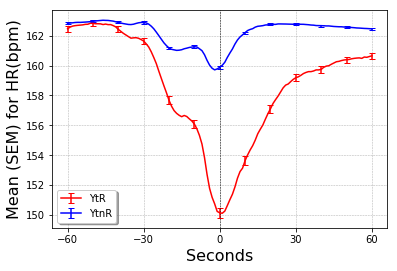

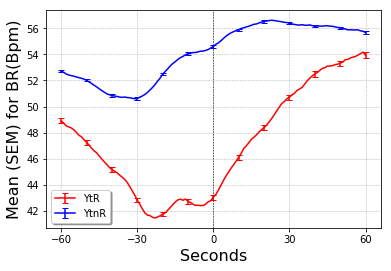

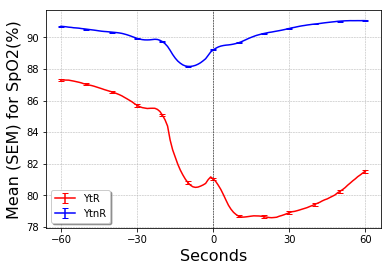

In [22]:
### Main part
##HR for yellow to red and to notred  
paramPlot(HR_yellow_to_red.iloc[:,:121],HR_yellow_to_notred.iloc[:,:121],'HR','yellow')
##BR for yellow to red and to notred   
paramPlot(BR_yellow_to_red.iloc[:,:121],BR_yellow_to_notred.iloc[:,:121],'BR','yellow') 
##SpO2 for yellow to red and to notred  
paramPlot(SpO2_yellow_to_red.iloc[:,:121],SpO2_yellow_to_notred.iloc[:,:121],'SpO2','yellow')

Upper figure shows the average of 63k YtnR and 12k YtR HR samples. It can be seen that both lines stay stable and nearly mixed together in the first 10 seconds and then they both drop dramatically until occurring. Moreover the average of YtR is lower than YtnR especially in dropping period and the valley of YtR is deeper, the heart rate at occurring point also has big difference. 
 <br>   Lower two figures illustrate the results for breathing rate (BR) and SpO2 respectively, it is clear that the trend of them is similar since BR and SpO2 is related, but SpO2 has more difference between YtR and YtnR. Therefore SpO2 could be a good indicator for classification.<br>Worth to note that the error bar here shows the standard error rather than standard deviation, the short error bar may be caused by the huge sample amount. Besides, this is the average value, we also need to observe some raw data to see whether we can get inspired.

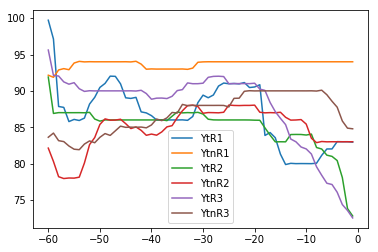

In [23]:
for i,j in zip(np.random.randint(SpO2_yellow_to_red.shape[0], size=3),range(3)):
    plt.plot(SpO2_yellow_to_red.iloc[i,:60],label='YtR%d'%(j+1))
    plt.plot(SpO2_yellow_to_notred.iloc[i,:60],label='YtnR%d'%(j+1))
    plt.legend()
plt.show()

It can be seen that YtR was likely to have a dramatic drop while YtnR was more stable. We could apply regression line to fit this and take the slope, rvalue and intercept as features

## Feature extraction

Due to our features should be easy to understand.We extracted features from our observations, literature and some domain knowledge.Then implement feature selection algorithm to find out most effective features<br>Firstly from figures above, some basic features were worth to try:<br>1.SpO2_Occ:SpO2 at occurring time instant of yellow alarm<br>2.SpO2_Min:Minimum of time SpO2 samples before occuring<br>3.SpO2_Mean:Mean of SpO2 samples before occuring<br>4.SpO2_BaseMin:SpO2 difference between minimum and baseline(mean of first 20s)<br>5.SpO2_Std:Standard deviation of SpO2 samples

Considering there could be some alarms happened before occuring, this may have some influence, the following features were extracted.<br>1.SpO2_TUR:Cumulative time under threshold of red alarm<br>2.SpO2_NTC_Y:Number of yellow alarm threshold crossing<br>3.SpO2_NTC_R:Number of red alarm threshold crossing.<br>

According to some related literature, some features may also work in this classification.<br>1.SpO2_DI:Delta index:average of the absolute differences between two successive mean value of SpO2 signal over 12-second interval.<br>2.SpO2_CTM:Central tendency measure with radius 1.5(calculated by selecting a radius of 1.5 with respect to the origin of a second-order difference plot and counting the number of point fall into the circle.)<br>3.SpO2_ApEn:Approximate Entropy with run length of 1 and tolerance window of 0.25*SpO2_Std.<br>4.SpO2_LZC:Lempel-Ziv complexity.

Correlation based features were also extracted.<br>1.HBcorr:Maximal value and corresponding lag of cross correlation between HR and BR with lag from -20s to 20s(5s step).<br>2.HScorr:Maximal value and corresponding lag of cross correlation between HR and SpO2with lag from -20s to 20s(5s step).<br>3.BScorr:Maximal value and corresponding lag of cross correlation between BR and SpO2 with lag from -20s to 20s(5s step).

Regression based features.<br>1.SpO2_slope:the slope of regression line with last 30 seconds.<br>2.SpO2_rvalue:the rvalue of regression line with last 30 seconds.<br>3.SpO2_intercept:the intercept of regression line with last 30 seconds.

Finally some categorical features were extracted, for instance, the alarm category of yellow alarms and some metadata of babies like birth weight, gender and gestational age.<br>All these features were extracted from SpO2,HR and BR parameters

In [27]:
### Feature extraction related functions
### Cumulative time under red threshold (TUR) as feature
def featTUR(df,thresh):
    ###No. of Nans means seconds which is less than thresh
    return df.apply(lambda x:x.where(x>thresh),axis=0).isnull().sum(axis=1).values
### No. of threshold crossing (NTC) as feature            
def featNTC(df,thresh):
    ###No. of ones after diff means the times it cross the thresh
    return (df.apply(lambda x:x.where(x>thresh),axis=0)
            .isnull().astype(int).diff(axis=1)==1).sum(axis=1).values

### Delta index as feature    
def featDI(df,seconds):
    temp=[np.max(df.iloc[:,i*seconds:(i+1)*seconds],axis=1)-np.min(df.iloc[:,i*seconds:
        (i+1)*seconds],axis=1) for i in range(int(np.floor(len(df.columns)/seconds)))]
    return np.mean(pd.concat(temp,axis=1),axis=1).values

### Central tendency meaturement as feature
def featCTM(df):
    t=df.diff(axis=1).dropna(axis=1,how='all')
    dis=np.sqrt(t.iloc[:,:-1].values**2+t.iloc[:,1:].values**2)
    ## Take the sum of first 95% elements as measurement instead of circle in original paper
    outlier=np.percentile(dis,95,axis=1)
    return [np.sum(c[c<=thresh]) for c,thresh in zip(dis,outlier)]

### Lempel_ziv_complexity as feature
def featLZC(df):
    ##Convert df into 1 0 sequence (string of characters like '00110') for faster lempel_ziv_complexity    
    df['thresh']=np.median(df,axis=1)
    df_seq=df.apply(lambda x:x.iloc[:-1]>x['thresh'],axis=1).values.astype(int)
    return [lempel_ziv_complexity(str(''.join(map(str,x)))) for x in df_seq]

### Approximate Entropy as feature    
def featApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

### Calculation correlation coefficient of two sequence
def vcorrcoef(X,Y):
    Xm = np.reshape(np.mean(X.values,axis=1),(X.values.shape[0],1))
    Ym = np.reshape(np.mean(Y.values,axis=1),(Y.values.shape[0],1))
    r_num = np.sum((X.values-Xm)*(Y.values-Ym),axis=1)
    r_den = np.sqrt(np.sum((X.values-Xm)**2,axis=1)*np.sum((Y.values-Ym)**2,axis=1))
    r = r_num/r_den
    return r

### Calculation correlation coefficient for all corresponding sequence in two dataframe
### (Maximal correlation coefficient and corresponding lag with normalization)
def xcorrcoef(df1,df2):
    start=int((df1.shape[1]-1)/-3)
    end=int((df1.shape[1]-1)/3)
    step=5
    df1=df1.apply(stats.zscore,axis=1)
    df2=df2.apply(stats.zscore,axis=1)
    coef=np.zeros((df1.shape[0],int((end-start)/step+1)))
    for lag,i in zip(range(start,end+1,step),range(coef.shape[1])):
        if lag<0:
            coef[:,i]=vcorrcoef(df1.iloc[:,:lag],df2.iloc[:,(-1*lag):])
        elif lag==0:
            coef[:,i]=vcorrcoef(df1,df2)
        else:
            coef[:,i]=vcorrcoef(df1.iloc[:,lag:],df2.iloc[:,:-1*lag])
    ##If std of params is 0, which means param is a constant, in this case we set coef as 0
    coef_max=np.max(np.abs(np.nan_to_num(coef)),axis=1)
    coef_lag=np.argmax(np.abs(np.nan_to_num(coef)), axis=1)*step+start
    return np.concatenate((coef_max.reshape(-1,1),coef_lag.reshape(-1,1)),axis=1)

### Extract specific category of each yellow alarm as feature   
def featCateg(para_to_red,para_to_notred,yellow_to_red,yellow_to_notred):
    return pd.concat([yellow_to_red.loc[
            yellow_to_red['AnnounceTime_yellow'].isin(para_to_red['Timestamp']),'Category_yellow'],
                yellow_to_notred.loc[
                        yellow_to_notred['AnnounceTime'].isin(para_to_notred['Timestamp']),'Category']]).values

### Clean meta data and save it
def cleanMeta():
    try:
        metadata = loadVariable('/metadata')
    except:
        metadata=pd.read_csv(abspath+'metadat.csv',skipfooter=3,usecols=[0,1,2,3,4,5]).rename(columns={"Code": "Baby"})
        metadata['Baby']=metadata.Baby.replace(['BB_1','BB_2','BB_3','BB_4','BB_5','BB_6','BB_7','BB_8','BB_9','BB_10','BB_11','BB_13','BB_14',
                'BB_15','BB_16','BB_17','BB_19','BB_20'],
                ['01_6f712b8a-89a9-4a1a-ad91-4b9ed6fc13ea','02_b2bd7687-8dda-4761-a849-ed3e51640b22','03_fd85bfb5-292e-4657-a430-1ee5c31f5f00',
                 '04_92f19a7a-3671-446b-ba91-0c21d7d9174d','05_14a1e090-ce93-4131-a2a9-ca8ca043ce98','06_69f39a14-7087-4f68-b91b-bc33a483e1bc',
                 '07_df1ef995-596c-403e-b490-e8d88a9b1bce','08_de07337a-e679-4fd3-b606-3ab106792edd','09_5b5b49c6-1539-47c7-919c-987a1c23ea34',
                 '10_68f7b1d9-309c-4448-8c25-be88590254c7','11_244d51f1-8788-403b-8eea-5ef489a02379','13_b825cb6f-4744-423c-a782-b67e3d62e359',
                 '14_c6b0bb8d-b512-48a1-81f1-4ad8054d9392','15_ce30cfa9-0148-4775-aed1-086e46d2d25f','16_b360d41c-2b87-4b73-95a9-33d0aa3c8fc5',
                 '17_f0fea76b-095b-484a-995e-7f11efc286d9','19_67749c57-efa7-49f5-8d3e-8b6a50fe4408','20_fcd8ed2e-b485-4acc-bad2-b467d25cb544']) 
        metadata['Gender']=metadata.Gender.replace(['M','J'],[1,0])
        metadata['GA_days']=metadata['GA_days']+metadata['GA_weeks']*7
        metadata.drop('GA_weeks',axis=1,inplace=True)
        metadata['DoB']=pd.to_datetime(metadata['DoB'],dayfirst=True)
        saveVariable(metadata,'/metadata')
    return metadata

### Extract meta information of babies as feature 
def featMeta(baby_tstamp,metadata):
    feat_meta=baby_tstamp.merge(metadata,how='left',on='Baby')
    feat_meta['Timestamp']=pd.to_datetime(feat_meta['Timestamp'])
    feat_meta['PMA_days']= [i.days for i in (feat_meta['Timestamp']-feat_meta['DoB'])]
    feat_meta.drop(['DoB','Timestamp','Baby'],axis=1,inplace=True)
    return feat_meta

### Extract Slope intercept and rvalue of regression for precedding 50s as feature
def featReg(data,paraname):
    return pd.DataFrame([stats.linregress(range(-50,1),data.iloc[r,-51:]
                                          ) for r in range(len(data))])[['slope','intercept','rvalue']].rename(
                                            {'slope': paraname+'_slope', 
                                             'intercept': paraname+'_intercept',
                                             'rvalue': paraname+'rvalue'}, axis='columns')
### Extract all basic features including statistic and non-linear features   
def featBasic(label,data,para_name):
    if 'Label' not in label.name:
        label.rename('Label',inplace=True)
    label=pd.DataFrame(label).reset_index(drop=True)
    ### Statistic Features   
    ### Params at occuring moment
    label[para_name+'_Occ']=data.loc[:,0].values
    ### Mean of preceding 3 mins
    label[para_name+'_Mean']=np.mean(data.values,axis=1)
    ### Minimal of preceding 3 mins
    label[para_name+'_Min']=np.min(data.values,axis=1)
    ### Baseline to Min
    label[para_name+'_BaseMin']=np.mean(data.iloc[:,:int(round(data.shape[1]/3))].values,axis=1)-np.min(data.values,axis=1) 
    ### Std
    label[para_name+'_Std']=np.std(data.values,axis=1)
    ###Cumulative time under red threshold
    if para_name=='SpO2':
        label[para_name+'_TUR']=featTUR(data,80)
    elif para_name=='HR':
        label[para_name+'_TUR']=featTUR(data,80)
    elif para_name=='BR':
        label[para_name+'_TUR']=featTUR(data,40)
    ### No. of threshold crossing (NTC) as feature
    if para_name=='SpO2':
        label[para_name+'_NTC_Y']=featNTC(data,85)
    elif para_name=='HR':
        label[para_name+'_NTC_Y']=featNTC(data,100)
    elif para_name=='BR':
        label[para_name+'_NTC_Y']=featNTC(data,50)
    if para_name=='SpO2':
        label[para_name+'_NTC_R']=featNTC(data,80)
    elif para_name=='HR':
        label[para_name+'_NTC_R']=featNTC(data,80)
    elif para_name=='BR':
        label[para_name+'_NTC_R']=featNTC(data,40)    
    ###Delta index
    label[para_name+'_DI']=featDI(data,12)
    ###Central tendency meature   
    label[para_name+'_CTM']=featCTM(data)
    ###Lempel–Ziv (LZ) complexity(Slow and little contribution)
    label[para_name+'_LZC']=featLZC(data.copy())
    ###Approximate Entropy (Very slow)
    label[para_name+'_ApEn']=pd.concat([data,label[para_name+'_Std']],
         axis=1).apply(lambda x:featApEn(x[:-1].values,1,0.25*x[para_name+'_Std']),axis=1)
    return label

In [25]:
### Main part of feature extraction
###Extract parameter data in preceding tw_param mins
SpO2_data=pd.concat([SpO2_yellow_to_red.iloc[:len(SpO2_yellow_to_red),:tw_param*60+1],
                                                 SpO2_yellow_to_notred.iloc[:len(SpO2_yellow_to_notred),:tw_param*60+1]
                                                 ]).reset_index(drop=True)
HR_data=pd.concat([HR_yellow_to_red.iloc[:len(HR_yellow_to_red),:tw_param*60+1],
                                                 HR_yellow_to_notred.iloc[:len(HR_yellow_to_notred),:tw_param*60+1]
                                                 ]).reset_index(drop=True)
BR_data=pd.concat([BR_yellow_to_red.iloc[:len(BR_yellow_to_red),:tw_param*60+1],
                                                 BR_yellow_to_notred.iloc[:len(BR_yellow_to_notred),:tw_param*60+1]
                                                 ]).reset_index(drop=True)
### Fill in label first
feat_SpO2=pd.Series(np.concatenate([np.ones(len(SpO2_yellow_to_red)),
                                    np.zeros(len(SpO2_yellow_to_notred))]),name='Label')        
### The shape of features df for 3 params is the same
feat_HR=feat_SpO2.copy()
feat_BR=feat_SpO2.copy()
### Create them
feat_SpO2=featBasic(feat_SpO2,SpO2_data,'SpO2')
feat_HR=featBasic(feat_HR,HR_data,'HR')
feat_BR=featBasic(feat_BR,BR_data,'BR')
meta=cleanMeta()
feat_categ=pd.concat([feat_SpO2.iloc[:,0],
                      featMeta(pd.concat([SpO2_yellow_to_red[['Baby','Timestamp']],SpO2_yellow_to_notred[['Baby','Timestamp']]]),meta),
                      pd.get_dummies(featCateg(SpO2_yellow_to_red,SpO2_yellow_to_notred,
                                               yellow_to_red,yellow_to_notred))],axis=1)
feat_corr=pd.concat([feat_SpO2.iloc[:,0],
                             pd.DataFrame(xcorrcoef(SpO2_data,HR_data),columns=['SH_corMax','SH_corLag']),
                             pd.DataFrame(xcorrcoef(SpO2_data,BR_data),columns=['SB_corMax','SB_corLag']),
                             pd.DataFrame(xcorrcoef(HR_data,BR_data),columns=['HB_corMax','HB_corLag'])],axis=1)
feat_reg = pd.concat([feat_SpO2.iloc[:,0],
                              featReg(SpO2_data,'SpO2'),
                              featReg(HR_data,'HR'),
                              featReg(BR_data,'BR')],axis=1)

In [28]:
## Full feature matrix
feat_full = pd.concat([feat_SpO2,
                       feat_BR.iloc[:,1:],
                       feat_HR.iloc[:,1:],
                       feat_corr.iloc[:,1:],
                       feat_categ.iloc[:,1:],
                       feat_reg.iloc[:,1:]
                       ],axis=1)

In [29]:
feat_full.head()

,Label,SpO2_Occ,SpO2_Mean,SpO2_Min,SpO2_BaseMin,SpO2_Std,SpO2_TUR,SpO2_NTC_Y,SpO2_NTC_R,SpO2_DI,...,SpO2 Low,SpO2_slope,SpO2_intercept,SpO2rvalue,HR_slope,HR_intercept,HRrvalue,BR_slope,BR_intercept,BRrvalue
0,1.0,81.050755,89.934629,80.992809,14.203074,5.507607,0,1,0,4.685892,...,1,-0.346721,80.179516,-0.947312,0.106661,119.667748,0.261893,-0.275897,7.341965,-0.932669
1,1.0,79.964310,89.535858,79.964310,15.563186,5.808996,4,2,2,4.662741,...,1,-0.349543,79.448478,-0.952554,-0.155105,141.850476,-0.644788,0.807759,43.170237,0.648106
2,1.0,82.054328,83.499712,79.930635,5.571863,3.068802,4,4,2,5.395539,...,1,0.001653,82.587808,0.012419,-0.283737,133.995444,-0.595621,0.312985,51.681808,0.261155
3,1.0,77.028722,87.427933,76.980656,14.947054,5.160166,9,1,1,5.230696,...,1,-0.323395,78.419880,-0.922373,-0.290578,141.854332,-0.921904,-0.954111,4.074722,-0.931885
4,1.0,77.054673,88.287369,76.984145,16.453695,5.911831,9,1,1,4.055130,...,1,-0.387091,77.592076,-0.957211,-0.326631,150.641664,-0.553814,0.957528,56.893161,0.555049


In [30]:
feat_full.shape

(66690, 64)

## Feature Selection

We chose ROC_AUC in cross-validation set to evaluate our model. Afterwards logistic regression and gradient boosting were implement with RFE feature selection algorithm. Finally best 5 features with highest AUC were selected

We didn't apply oversample or undersample to deal with the imbalanced class, since in our application we pay more attention to specificity rather than sensitivity

In [31]:
### Feature selection related functions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def show_result(clf,train_scaled,test_scaled,y_train,y_test,title):
    y_pred_train = clf.predict(train_scaled)
    y_pred_test = clf.predict(test_scaled)
    plt.figure()
    plot_confusion_matrix(confusion_matrix(y_train,y_pred_train),
                          classes=['Not red','Red'],
                          title='%s_train'%title,
                          normalize=True)
    plt.figure()
    plot_confusion_matrix(confusion_matrix(y_test,y_pred_test),
                          classes=['Not red','Red'],
                          title='%s_test'%title,
                          normalize=True)
    plt.show()

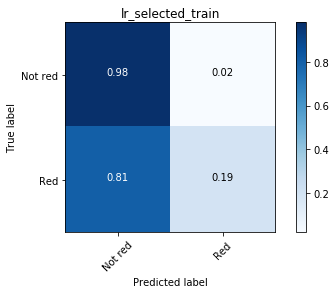

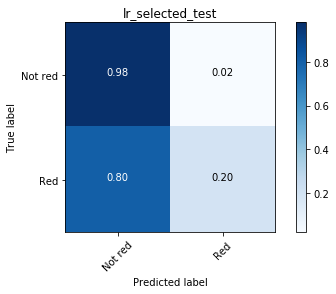

Selected features of lr:
[['SpO2_Occ']
 ['BR_Occ']
 ['HR_Occ']
 ['HR_Mean']
 ['HR_slope']]
AUC of lr in 5fold CV:0.84


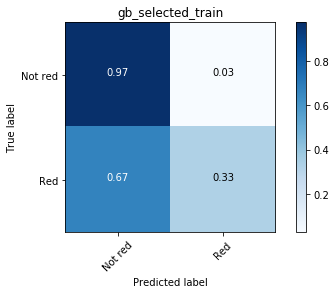

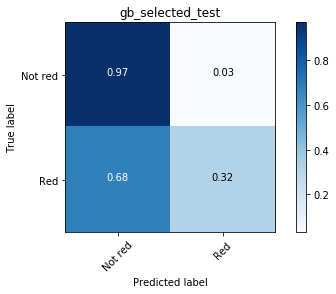

Selected features of gb:
[['SpO2_Occ']
 ['HR_Occ']
 ['BW']
 ['SpO2_intercept']
 ['HR_slope']]
AUC of gb in 5fold CV:0.86


In [32]:
### Main part of feature selection
## Split train and test
X_train,X_test,y_train,y_test = train_test_split(feat_full.iloc[:,1:],
                                                 feat_full.Label,
                                                 test_size=0.1,
                                                 random_state=0,
                                                 stratify=feat_full.Label)
## Normalization
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
## Classification
for name in ['lr','gb']:
    if name=='lr':
        clf=LogisticRegression()
    elif name=='gb':
        clf=GradientBoostingClassifier()
    n_feat = 5 ##No. of selected features
    ## Feature selection with RFE
    selector = RFE(clf, n_feat, 1)
    selector = selector.fit(X_train_scaled, y_train)
    feat_selected = pd.DataFrame(feat_full.iloc[:,1:].columns.values[selector.support_])
    auc_selected_cv = np.mean(cross_val_score(selector,X_train_scaled,y_train,cv=5,scoring='roc_auc'))
    show_result(selector,X_train_scaled,X_test_scaled,y_train,y_test,'%s_selected'%name)
    print('Selected features of {}:\n{}\nAUC of {} in 5fold CV:{:.2f}'.format(name,feat_selected.values,name,auc_selected_cv))  

Highest AUC(0.86) came from tree-based algorithm Gradient boosting with five features.Specificity was 0.97 and sensitivity was 0.32

## Discussion

We got AUC of 0.86 and specificity of 0.97 with 5 simple features. Moreover the result in test set was quite similar with that in training set which means the generalization is good and no overfitting issue. However the sensitivity need to be optimized. This can be done with parameter tuning in algorithm and further feature exploration. Alternatively, stacking with several different algorithm may also help. In addition to this, some other feature selection algorithm can be developed in this project.